In [1]:
import tifffile
import numpy as np
from scipy.ndimage import sobel, laplace, generic_gradient_magnitude, prewitt
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, cohen_kappa_score

In [2]:
with tifffile.TiffFile("../dataset/labeled_data/train/train_XZ/tr_orig_XZ.tif") as tif:
    print("TRAIN", tif.pages[0].sizes)
    raw_train_data = tif.asarray()

with tifffile.TiffFile("../dataset/labeled_data/train/train_XZ/tr_seg_XZ.tif") as tif:
    raw_train_labels = tif.asarray()

with tifffile.TiffFile("../dataset/labeled_data/test/test_YZ/test_orig_YZ.tif") as tif:
    print("TEST", tif.pages[0].sizes)
    raw_test_data = tif.asarray()

with tifffile.TiffFile("../dataset/labeled_data/test/test_YZ/test_seg_YZ.tif") as tif:
    raw_test_labels = tif.asarray()

TRAIN {'height': 600, 'width': 600}
TEST {'height': 425, 'width': 425}


In [3]:
def generate_features(data):
    data = (data / 255).reshape((-1, 1))

    sobel_x = sobel(data, 0)
    sobel_y = sobel(data, 1)
    sobel_grad_magn = generic_gradient_magnitude(data, sobel)

    d2x = laplace(data)

    prewitt_x = prewitt(data, 0)
    prewitt_y = prewitt(data, 1)
    prewitt_grad_magn = generic_gradient_magnitude(data, prewitt)

    features = np.hstack([data, sobel_x, sobel_y, sobel_grad_magn, d2x, prewitt_x, prewitt_y, prewitt_grad_magn])
    return features

In [4]:
# train_data = (train_data / 255).reshape((-1, 1))
train_data = generate_features(raw_train_data)
train_labels = raw_train_labels.flatten().astype(np.int8)
# test_data = (test_data / 255).reshape((-1, 1))
test_data = generate_features(raw_test_data)
test_labels = raw_test_labels.flatten().astype(np.int8)

In [5]:
def remove_zero_labels(x, y):
    mask = y != 0
    X = x[mask]
    Y = y[mask] - 1
    return X, Y

In [6]:
X_train, Y_train = remove_zero_labels(train_data, train_labels)
X_test, Y_test = remove_zero_labels(test_data, test_labels)

In [7]:
print(X_train.shape, Y_train.shape)

(268828, 8) (268828,)


In [8]:
def predict_and_plot(model):
    train_preds = eval(model, train_data, train_labels, "train")
    test_preds = eval(model, test_data, test_labels, "test")

    plt.subplot(2, 2, 1)
    pred_img = train_preds.reshape((600, 600)) + 1
    plt.imshow(pred_img)

    plt.subplot(2, 2, 2)
    gt_img = train_labels.reshape((600, 600))
    plt.imshow(gt_img)

    plt.subplot(2, 2, 3)
    pred_img = test_preds.reshape((425, 425)) + 1
    plt.imshow(pred_img)

    plt.subplot(2, 2, 4)
    gt_img = test_labels.reshape((425, 425))
    plt.imshow(gt_img)

def eval(model, x, y, prefix):
    p_preds = model.predict_proba(x)
    preds = np.argmax(p_preds, axis=1)

    P, Y = remove_zero_labels(preds, y)

    print(f"Precision {prefix}", precision_score(Y, P, average="macro"))
    print(f"Recall {prefix}", recall_score(Y, P, average="macro"))
    print(f"F1 {prefix}", f1_score(Y, P, average="macro"))
    print(f"AP {prefix}", average_precision_score(Y, p_preds[y != 0], average="macro"))
    print(f"Kappa {prefix}", cohen_kappa_score(Y, P))

    return preds

Precision train 0.9401013029147504
Recall train 0.736424029265291
F1 train 0.8134359244691508
AP train 0.9192702314396953
Kappa train 0.9024198106756215
Precision test 0.31878508278529377
Recall test 0.32094072876973456
F1 test 0.317221180122403
AP test 0.26138893368819854
Kappa test 0.5843884152963023


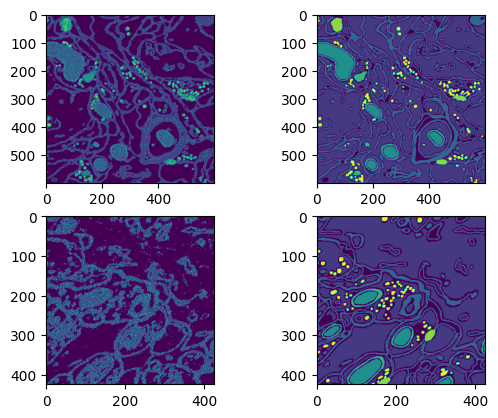

In [9]:
tree = DecisionTreeClassifier()

tree.fit(X_train, Y_train)

predict_and_plot(tree)

Precision train 0.8927592040606859
Recall train 0.7688761679196019
F1 train 0.8212024011897568
AP train 0.9342209307160787
Kappa train 0.9033769639743421
Precision test 0.32798075112700265
Recall test 0.3254993360982729
F1 test 0.31928762256653676
AP test 0.31453921244883304
Kappa test 0.6180277384006658


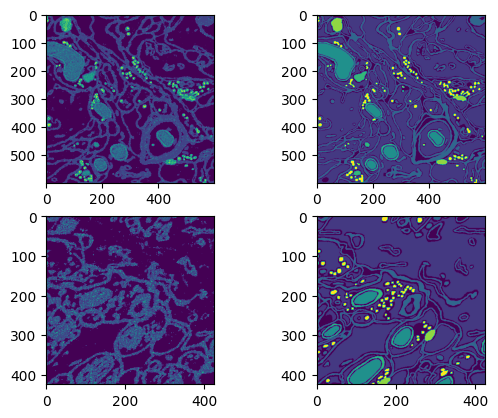

In [10]:
rf = RandomForestClassifier()

rf.fit(X_train, Y_train)

predict_and_plot(rf)

/home/shov/miniconda3/envs/volume/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/shov/miniconda3/envs/volume/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision train 0.27277054399278833
Recall train 0.31973926352562226
F1 train 0.29256365679918633
AP train 0.22839459898282286
Kappa train 0.7157374639335936


/home/shov/miniconda3/envs/volume/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision test 0.25888437426195476
Recall test 0.317581529140568
F1 test 0.28084580229558925
AP test 0.21176041728675343
Kappa test 0.6714982578442705


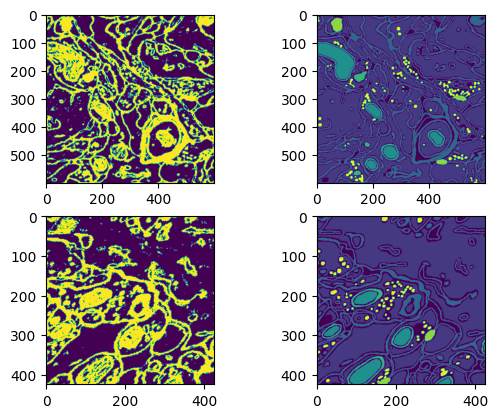

In [11]:
ab = AdaBoostClassifier()

ab.fit(X_train, Y_train)

predict_and_plot(ab)

Precision train 0.8800233853784615
Recall train 0.32180396345197987
F1 train 0.2953864243976094
AP train 0.3780149521095177
Kappa train 0.7226204580482579


/home/shov/miniconda3/envs/volume/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision test 0.28996380564105595
Recall test 0.3183612042845941
F1 test 0.28181874605335
AP test 0.3547363109142779
Kappa test 0.6762018679683619


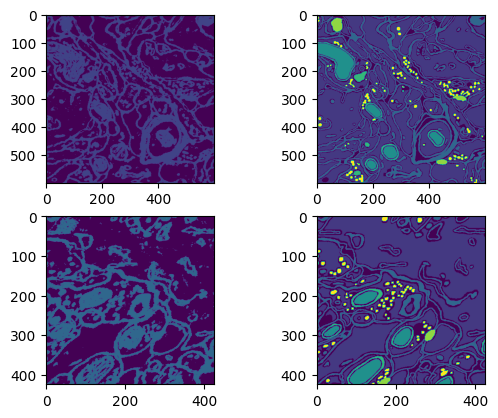

In [12]:
gb = GradientBoostingClassifier()

gb.fit(X_train, Y_train)

predict_and_plot(gb)